# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from datetime import date

import matplotlib.pyplot as plt
import matplotlib as mpl


# Processing Data

In [2]:
# Reading excel file
books_read = pd.read_excel('info.xlsx', sheet_name='Books Read')
books_read = books_read.drop(columns=['Pages Read', 'Pages Read.1', 'Complete', 'End Date', 'Progress'], errors='ignore')
books_read['Date'] = pd.to_datetime(books_read['Date'], format='%d/%m/%Y')
books_read = books_read.sort_values(by=['Date', 'Title'])
books_read['Category'] = books_read['Category'].str.strip()



books_read['Pages Read'] = (
    books_read
    .groupby('Title')['Current Page']
    .diff()
)

# Get the first current page per book entry and use it to fill NaNs
mask = books_read['Pages Read'].isna()
books_read.loc[mask, 'Pages Read'] = books_read.loc[mask, 'Current Page']

# Plotting

## Pages Read per Day

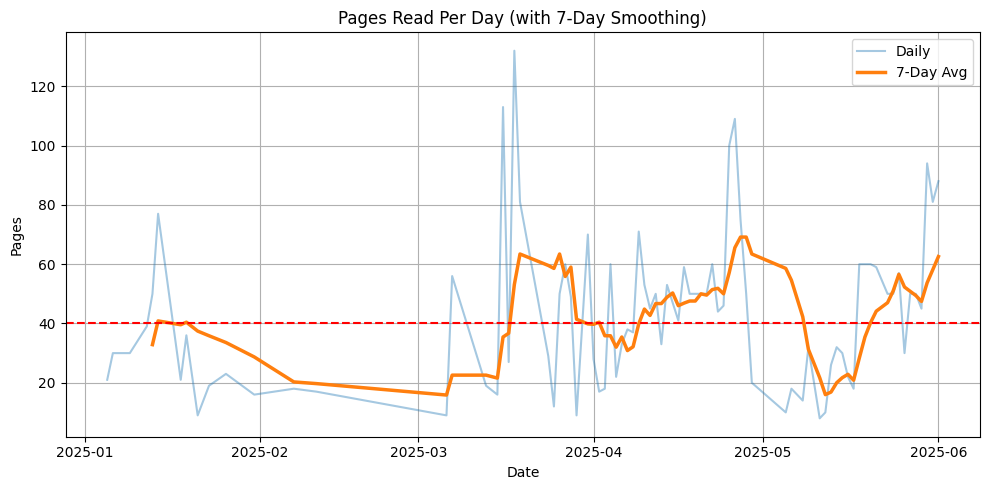

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Daily pages read across all books
daily = books_read.groupby('Date')['Pages Read'].sum().reset_index()
daily.to_csv('daily_pages_read.csv', index=False)
daily['Rolling Avg'] = daily['Pages Read'].rolling(window=7).mean()

plt.figure(figsize=(10, 5))
sns.lineplot(data=daily, x='Date', y='Pages Read', label='Daily', alpha=0.4)
sns.lineplot(data=daily, x='Date', y='Rolling Avg', label='7-Day Avg', linewidth=2.5)
plt.title("Pages Read Per Day (with 7-Day Smoothing)")
plt.xlabel("Date")
plt.ylabel("Pages")
plt.grid(True)
plt.legend()
plt.axhline(40, color='red', linestyle='--', label='Daily Goal') # 40 pages daily goal
plt.tight_layout()
plt.show()

## Reading Progress per book

/var/folders/df/pxgr9rlj23l9blb9tg39vm_80000gn/T/ipykernel_51995/2955350340.py:20: UserWarning: Glyph 128218 (\N{BOOKS}) missing from current font.
  plt.tight_layout()
/Users/cristianmojica/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128218 (\N{BOOKS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


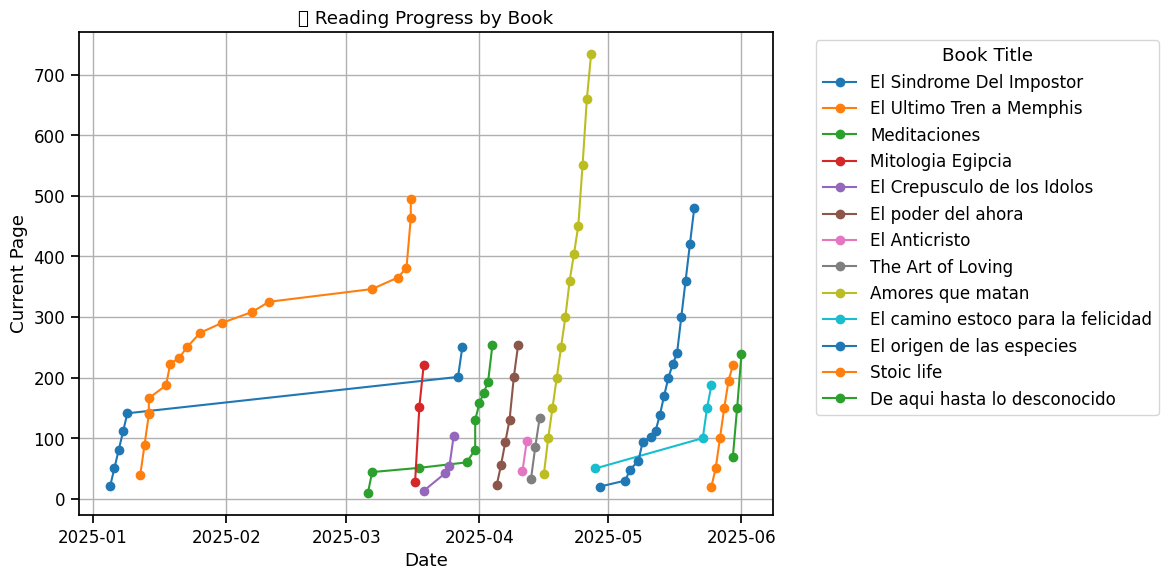

In [27]:
plt.figure(figsize=(12, 6))

# Get titles sorted by first appearance
book_order = (
    books_read.groupby('Title')['Date']
    .min()
    .sort_values()
    .index
)

# Plot using the sorted order
for title in book_order:
    group = books_read[books_read['Title'] == title]
    plt.plot(group['Date'], group['Current Page'], marker='o', label=title)

plt.title("📚 Reading Progress by Book")
plt.xlabel("Date")
plt.ylabel("Current Page")
plt.legend(title="Book Title", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

## Read by Category

/var/folders/df/pxgr9rlj23l9blb9tg39vm_80000gn/T/ipykernel_51995/2255694434.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_pages.values, y=category_pages.index, palette='viridis')


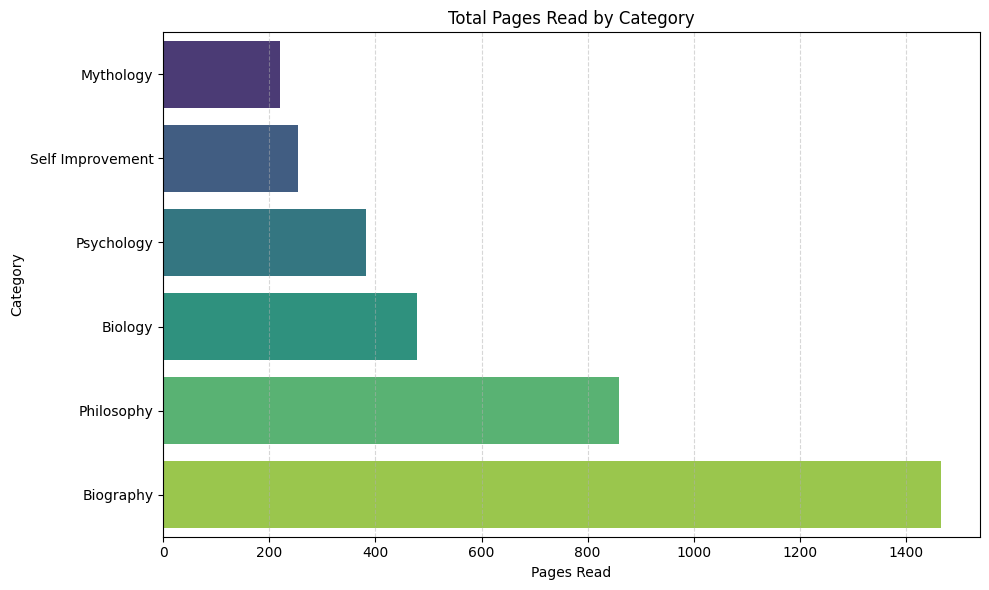

In [5]:

category_pages = books_read.groupby('Category')['Pages Read'].sum().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_pages.values, y=category_pages.index, palette='viridis')
plt.title("Total Pages Read by Category")
plt.xlabel("Pages Read")
plt.ylabel("Category")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

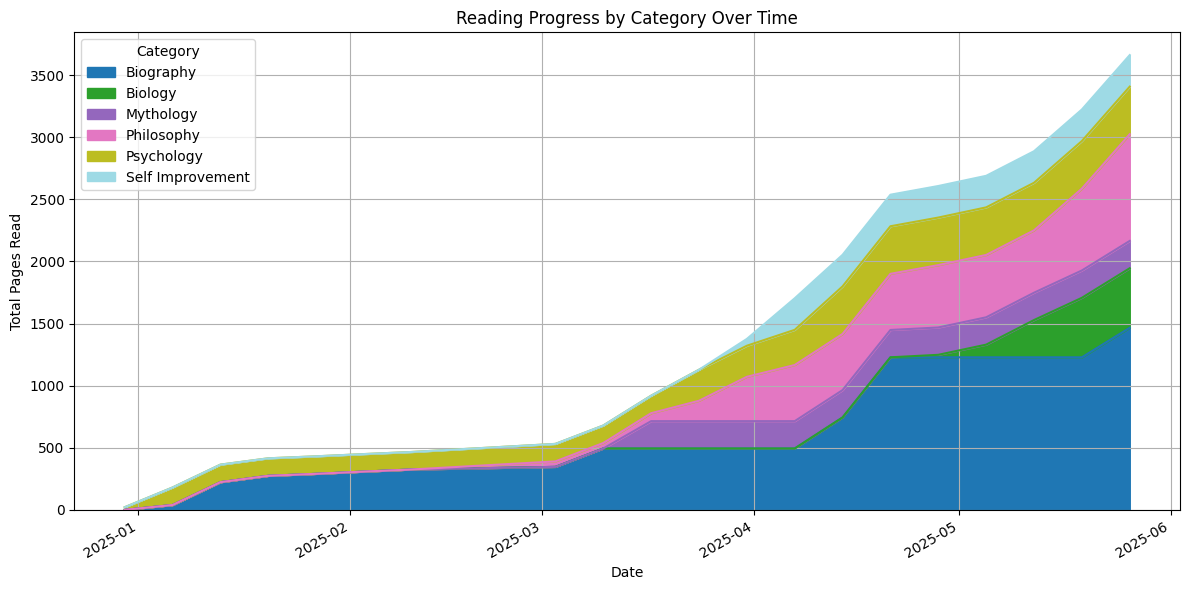

In [10]:
books_read['Date'] = pd.to_datetime(books_read['Date'])

# Group by Date and Category
books_read['Week'] = books_read['Date'].dt.to_period('W').apply(lambda r: r.start_time)

pivot = books_read.pivot_table(index='Week', columns='Category', values='Pages Read', aggfunc='sum').fillna(0)

pivot = pivot.cumsum()  # Optional: cumulative reading

pivot.plot.area(figsize=(12, 6), colormap='tab20')
plt.title("Reading Progress by Category Over Time")
plt.ylabel("Total Pages Read")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()

## Score per Week

/var/folders/df/pxgr9rlj23l9blb9tg39vm_80000gn/T/ipykernel_51995/2111071068.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finished_books['Week'] = finished_books['Date'].dt.to_period('W').apply(lambda r: r.start_time)
/var/folders/df/pxgr9rlj23l9blb9tg39vm_80000gn/T/ipykernel_51995/2111071068.py:49: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  plt.tight_layout()
/Users/cristianmojica/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129517 (\N{COMPASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


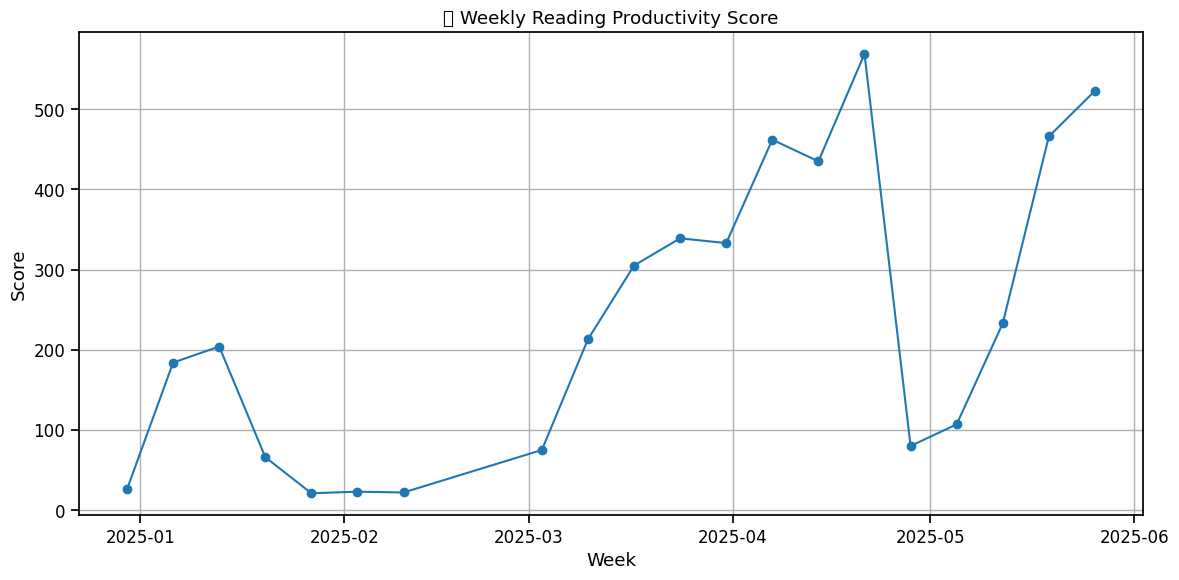

In [ ]:

# Ensure dates are datetime
books_read['Date'] = pd.to_datetime(books_read['Date'])

# 1. Group by week
books_read['Week'] = books_read['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# 2. Pages read per week
pages = books_read.groupby('Week')['Pages Read'].sum()

# 3. Active days per week
days_active = books_read.groupby('Week')['Date'].nunique()

# 4. Books finished: when current page == total pages
# First, get the last entry for each book
last_entries = books_read.sort_values('Date').groupby('Title').tail(1)
finished_books = last_entries[last_entries['Current Page'] == last_entries['Pages']]

# Count how many books were finished each week
finished_books['Week'] = finished_books['Date'].dt.to_period('W').apply(lambda r: r.start_time)
books_finished = finished_books.groupby('Week').size()

# 5. Combine all into one score DataFrame
score_df = pd.DataFrame({
    'Pages Read': pages,
    'Days Active': days_active,
    'Books Finished': books_finished
}).fillna(0)

# 6. Calculate total score
score_df['Productivity Score'] = (
    score_df['Pages Read'] * 1 +
    score_df['Days Active'] * 5 +
    score_df['Books Finished'] * 50
)

score_df = score_df.sort_index()




import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(score_df.index, score_df['Productivity Score'], marker='o', label='Productivity Score')
plt.title('🧭 Weekly Reading Productivity Score')
plt.xlabel('Week')
plt.ylabel('Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
books_read.groupby('Category').apply(lambda g: g.groupby('Title')['Pages Read'].sum().mean())

,Pages Read,Days Active,Books Finished,Productivity Score
Week,,,,
2024-12-30,21.0,1,0.0,26.0
2025-01-06,159.0,5,0.0,184.0
2025-01-13,184.0,4,0.0,204.0
2025-01-20,51.0,3,0.0,66.0
2025-01-27,16.0,1,0.0,21.0
2025-02-03,18.0,1,0.0,23.0
2025-02-10,17.0,1,0.0,22.0
2025-03-03,65.0,2,0.0,75.0
2025-03-10,148.0,3,1.0,213.0


# Processing MD file with insights

In [9]:
books_read.groupby('Category').apply(lambda g: g.groupby('Title')['Pages Read'].sum().mean())

Category
Biography           488.666667
Biology             479.000000
Mythology           220.000000
Philosophy          171.800000
Psychology          191.500000
Self Improvement    254.000000
dtype: float64

In [26]:
score_df

,Pages Read,Days Active,Books Finished,Productivity Score
Week,,,,
2024-12-30,21.0,1,0.0,26.0
2025-01-06,159.0,5,0.0,184.0
2025-01-13,184.0,4,0.0,204.0
2025-01-20,51.0,3,0.0,66.0
2025-01-27,16.0,1,0.0,21.0
2025-02-03,18.0,1,0.0,23.0
2025-02-10,17.0,1,0.0,22.0
2025-03-03,65.0,2,0.0,75.0
2025-03-10,148.0,3,1.0,213.0
